In [7]:
import sys
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])

from time import sleep, time
from functools import partial
from ipywidgets import interact, ToggleButton, FloatSlider
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import cm
import meshcat
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pydrake.all
from IPython.display import display, HTML

import scipy as sp
import scipy.interpolate

import pydrake.all
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, WrapToSystem, LinearSystem, PlanarSceneGraphVisualizer, SceneGraph, Simulator, VectorSystem)
from pydrake.systems.jupyter_widgets import WidgetSystem
from pydrake.math import sin, cos
from pydrake.trajectories import PiecewisePolynomial
#from pydrake.solvers._mathematicalprogram_py import MathematicalProgram, SolutionResult, SolverType
#from pydrake.systems.framework import VectorSystem
from pydrake.systems.controllers import LinearQuadraticRegulator
#from pydrake._symbolic_py import Variables, MonomialBasis, Variable, Jacobian

from pydrake.systems.controllers import (DynamicProgrammingOptions,
                                         FittedValueIteration, PeriodicBoundaryCondition)

import underactuated
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend, running_as_notebook
from underactuated.meshcat_utils import plot_surface
import underactuated.meshcat_utils as mutil

import graphviz
plt.rcParams.update({"savefig.transparent": True})

from pydrake.systems.framework import BasicVector_, LeafSystem_, PortDataType
from pydrake.systems.pyplot_visualizer import PyPlotVisualizer
from pydrake.systems.scalar_conversion import TemplateSystem

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [11]:
@TemplateSystem.define("DifferentiableRobotSystem_")
def DifferentiableRobotSystem_(T):
    """
    Models the 0+4 all-omni robot in a Autodiff-compatible LeafSystem
    """
    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            self.DeclareVectorInputPort("u", BasicVector_[T](2)) # Two inputs (left voltage, right voltage)
            self.DeclareVectorOutputPort("x", BasicVector_[T](6), # Six states 
                                         self.CopyStateOut) # don't tread on me (or my states)
            self.DeclareContinuousState(3, 3, 0) # no discrete allowed!
            
            self.mass = 52 # kg
            self.width = 0.75 # m
            self.length = 1.25 # m
            self.moi = 6 # kg-m^2
            self.com = np.asarray([0, 0]) # CoM simplified to (0,0)
        
            # wheelbase parameters
            self.wheel_radius = (6 / 39.37) / 2.0 # 4" wheels
            self.wheelbase_width = 0.6 # m, NOT RADIUS
            self.wheelbase_length = 1.0 # m, this shouldn't actually matter
        
            self.b_fwd = 10 # forward viscous friction, in n/m/s
            self.b_lat = 20 # lateral viscous friction, in n/m/s
        
        
            # motor parameters
            self.max_voltage = 12 # V
            self.nominal_voltage = 12 # V
            self.gear_ratio = 7 # 7:1 gear ratio
            self.free_speed = (5330 / 60) * 2 * np.pi # rad/s
            self.free_current = 2.7 # A
            self.stall_current = 133 # A
            self.stall_torque = 2.41 # n-m
        
            self.num_motors_per_gearbox = 2
        
            self.stall_torque *= self.num_motors_per_gearbox
            self.stall_current *= self.num_motors_per_gearbox
            self.free_current *= self.num_motors_per_gearbox
        
            self.motor_resistance = self.nominal_voltage/self.stall_current # ohm
            self.kv = self.free_speed/(self.nominal_voltage - self.motor_resistance * self.free_current) # rad/s/V
            self.kt = self.stall_torque/self.stall_current # n-m/A
            
        def _construct_copy(self, other, converter=None): # stupid 
            Impl._construct(self, converter=converter)
        
        def CopyStateOut(self, context, output): # stupid
            x = context.get_continuous_state_vector().CopyToVector()
            y = output.SetFromVector(x)

            
        def f(self, x, u): # Takes in current state, returns xdot
            (motor_voltage_l, motor_voltage_r) = u # all inputs
            (pos_xdot, pos_ydot, pos_thetadot,
             pos_x, pos_y, pos_theta) = x # all states
        
            #v_vec = np.asarray([pos_xdot, pos_ydot]) # velocity vector
            #rot = np.asarray( # rotation vector for current theta
            #    [
            #        [np.cos(-pos_theta), -np.sin(-pos_theta)],
            #        [np.sin(-pos_theta), np.cos(-pos_theta)]
            #    ]
            #)
            #v_vec_rot = rot @ v_vec # velocity rotated to current robot reference frame
            #c = np.cos(-pos_theta)
            c = np.cos(-pos_theta)
            s = np.sin(-pos_theta)
            #v_vec_rot = [c * pos_xdot + -s * pos_ydot, s * pos_xdot + c * pos_ydot]
                
            
            #fwd_vel = pos_xdot * np.cos(pos_theta) + pos_ydot * np.sin(pos_theta)
            #lat_vel = pos_xdot * np.sin(pos_theta) + pos_ydot * np.cos(pos_theta)
            
            #fwd_vel = v_vec_rot[0]
            #lat_vel = v_vec_rot[1]
            
            fwd_vel = c * pos_xdot + -s * pos_ydot
            lat_vel = s * pos_xdot + c * pos_ydot

            fwd_ffriction = fwd_vel * self.b_fwd # Force of friction
            #lat_ffriction = np.tanh(10*lat_vel) * self.mass * 9.82 * 0.1 + lat_vel * self.b_lat
            lat_ffriction = lat_vel * self.b_lat
            fwd_afriction = fwd_ffriction/self.mass # Acceleration due to friction
            lat_afriction = lat_ffriction/self.mass
            
            ss_l = fwd_vel - pos_thetadot * self.wheelbase_width # L/R wheel surface speed
            ss_r = fwd_vel + pos_thetadot * self.wheelbase_width
            
            motor_rpm_l = (ss_l / (self.wheel_radius)) * self.gear_ratio # L/R wheel motor RPM
            motor_rpm_r = (ss_r / (self.wheel_radius)) * self.gear_ratio
            
            motor_bemf_l = motor_rpm_l * 1/self.kv # motor back-emf, V
            motor_armature_v_l = motor_voltage_l - motor_bemf_l # actual motor armature voltage, V
            motor_current_l = motor_armature_v_l / self.motor_resistance # motor drawn current, A
            motor_torque_l = motor_current_l * self.kt # motor output torque, n-m
            wheel_torque_l = motor_torque_l * self.gear_ratio # wheel output torque, n-m
            wheel_force_l = wheel_torque_l / self.wheel_radius # wheel output force to ground, n
            
            motor_bemf_r = motor_rpm_r * 1/self.kv # motor back-emf, V
            motor_armature_v_r = motor_voltage_r - motor_bemf_r # actual motor armature voltage, V
            motor_current_r = motor_armature_v_r / self.motor_resistance # motor drawn current, A
            motor_torque_r = motor_current_r * self.kt # motor output torque, n-m
            wheel_torque_r = motor_torque_r * self.gear_ratio # wheel output torque, n-m
            wheel_force_r = wheel_torque_r / self.wheel_radius # wheel output force to ground, n
        
            fwd_accel = (wheel_force_l + wheel_force_r) / self.mass # N / kg = m/s^2

            xddot = (fwd_accel-fwd_afriction) * np.cos(pos_theta) - lat_afriction * np.cos(pos_theta+np.pi/2)
            yddot = (fwd_accel-fwd_afriction) * np.sin(pos_theta) - lat_afriction * np.sin(pos_theta+np.pi/2)
            
            radial_accel = (wheel_force_r - wheel_force_l) * self.wheelbase_width / self.moi # in N * m / kg-m^2 = rad/s^2
            thetaddot = radial_accel
    
            # [pos_xddot, pos_yddot, pos_thetaddot, pos_xdot, pos_ydot, pos_thetadot]
            return np.array([xddot, yddot, thetaddot, pos_xdot, pos_ydot, pos_thetadot])
        
        def DoCalcTimeDerivatives(self, context, derivatives): # Jank f(x,u) into PyDrake Happy Fun Time Undocumented Function format
            x = context.get_continuous_state_vector().CopyToVector()
            u = self.EvalVectorInput(context, 0).CopyToVector()
            dx = self.f(x,u)
            derivatives.get_mutable_vector().SetFromVector(dx)
            
        def test_square(self, x): # Can we just slap fcns into a class and have em autodiff'd? 
            return x**2
        
    return Impl

DifferentiableRobotSystem = DifferentiableRobotSystem_[None]  # Default instantiation

In [12]:
def animate_results(time_vector, data_array, animation_fps=30, speed_multiple=1, use_html5_video=False, save=False):
    # Need to interpolate time/data b/c nonlinear sampled from the simulation
    if data_array.shape[0] == 8:
        vl, vr, xdot,ydot,thetadot,x,y,theta = data_array # destructure logger array
    else:
        xdot,ydot,thetadot,x,y,theta = data_array # destructure logger array

    
    assert (len(time_vector.transpose()) == len(time_vector))
    data_len = len(time_vector)
    end_time = time_vector[-1]
    num_samplepts = int(end_time * animation_fps)
    time_vec_interp = np.linspace(0, end_time, num_samplepts)
    
    xdot_interp = sp.interpolate.interp1d(time_vector, xdot, kind='linear')(time_vec_interp)
    ydot_interp = sp.interpolate.interp1d(time_vector, ydot, kind='linear')(time_vec_interp)
    thetadot_interp = sp.interpolate.interp1d(time_vector, thetadot, kind='linear')(time_vec_interp)
    x_interp = sp.interpolate.interp1d(time_vector, x, kind='linear')(time_vec_interp)
    y_interp = sp.interpolate.interp1d(time_vector, y, kind='linear')(time_vec_interp)
    theta_interp = sp.interpolate.interp1d(time_vector, theta, kind='linear')(time_vec_interp)
    
    robot_width = 0.75
    robot_length = 1.25
    
    #fig = plt.figure(figsize=(5, 4))
    fig = plt.figure()
    ax = fig.add_subplot(autoscale_on=False,
                         xlim=(np.min(x_interp)-3, np.max(x_interp+3)),
                         ylim=(np.min(y_interp)-3, np.max(y_interp+3)))
    ax.set_aspect('equal')
    ax.grid()
    
    robot, = ax.plot([], [], '-', lw=2)
    trajectory, = ax.plot([], [], '-', lw=2)

    def draw(i):
        robot_pt1 = np.asarray([robot_width/2, robot_length/2])
        robot_pt2 = np.asarray([-robot_width/2, robot_length/2])
        robot_pt3 = np.asarray([-robot_width/2, -robot_length/2])
        robot_pt4 = np.asarray([robot_width/2, -robot_length/2])
        
        rot = np.asarray(
            [
                [np.cos(theta_interp[i]+np.pi/2), -np.sin(theta_interp[i]+np.pi/2)],
                [np.sin(theta_interp[i]+np.pi/2), np.cos(theta_interp[i]+np.pi/2)]
            ]
        )
        
        robot_pt1 = rot @ robot_pt1
        robot_pt2 = rot @ robot_pt2
        robot_pt3 = rot @ robot_pt3
        robot_pt4 = rot @ robot_pt4
        
        pos = np.asarray([x_interp[i],y_interp[i]])
        robot_pt1 += pos
        robot_pt2 += pos
        robot_pt3 += pos
        robot_pt4 += pos
        
        robot.set_data(
            [i[0] for i in [robot_pt1, robot_pt2, robot_pt3, robot_pt4, robot_pt1]],
            [i[1] for i in [robot_pt1, robot_pt2, robot_pt3, robot_pt4, robot_pt1]]
        )
        
        trajectory.set_data(x_interp[0:i],y_interp[0:i])
        return [robot]
    
    ani = animation.FuncAnimation(fig, draw, num_samplepts, interval=(1000//animation_fps)//speed_multiple, blit=True, repeat=False)

    plt.close('all')

    if use_html5_video:
        display(HTML(ani.to_html5_video()))
    else:
        display(HTML(ani.to_jshtml()))
        
    if save:
        ani.save('render.mp4', writer='ffmpeg', codec='h264', dpi=240)
            

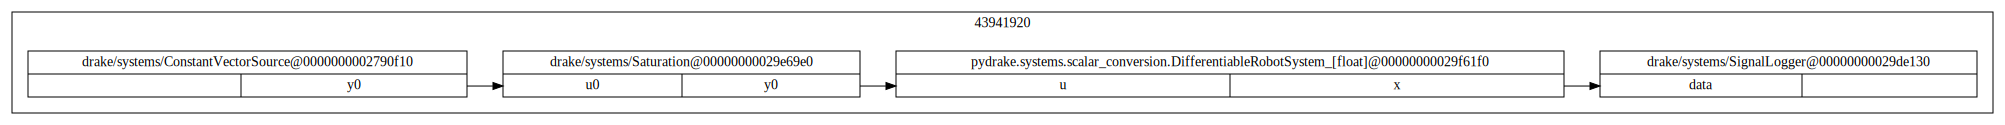

In [13]:
from pydrake.all import (DiagramBuilder, SignalLogger, ConstantVectorSource, Saturation)
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
constinput = builder.AddSystem(ConstantVectorSource([12,8]))
sat = builder.AddSystem(Saturation([-12,-12], [12,12]))
system = builder.AddSystem(DifferentiableRobotSystem())
logger = builder.AddSystem(SignalLogger(6))
builder.Connect(system.get_output_port(0), logger.get_input_port(0))
builder.Connect(constinput.get_output_port(0), sat.get_input_port(0))
builder.Connect(sat.get_output_port(0), system.get_input_port(0))
#builder.Connect(constinput.get_output_port(0), system.get_input_port(0))
diagram = builder.Build()

# Visualize
from graphviz import Source
string = diagram.GetGraphvizString()
Source(string)

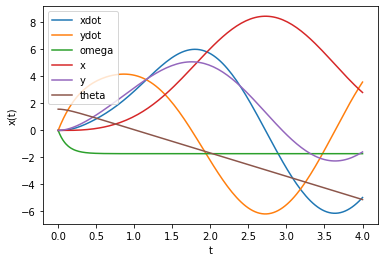

In [14]:
import matplotlib.pyplot as plt
from pydrake.all import (Simulator)

simulator = Simulator(diagram)
logger.reset()

context = simulator.get_mutable_context()
# xdot, ydot, thetadot, x, y, theta
context.SetContinuousState([0,0,0,0,0,np.pi/2])

# Set the initial conditions, x(0).
#state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
#state.SetFromVector([0,0,0,0,0,0])

# Simulate for 10 seconds.
simulator.AdvanceTo(4)

# Plot the results.
plt.plot(logger.sample_times(), logger.data().transpose())
plt.xlabel('t')
plt.ylabel('x(t)');
plt.legend(["xdot", "ydot", "omega", "x", "y", "theta"])
plt.show()

In [15]:
animate_results(logger.sample_times(), logger.data(), animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

In [16]:
from pydrake.all import DirectCollocation, PiecewisePolynomial, Solve

def plot_traj(xtraj, utraj):
    x_trajectory = xtraj
    u_trajectory = utraj
    fig, ax = plt.subplots()
    tvec = np.linspace(x_trajectory.start_time(), x_trajectory.end_time(), 100)
    dat = np.asarray([np.hstack([u_trajectory.value(t).transpose()[0],x_trajectory.value(t).transpose()[0]]) for t in tvec])
    plt.plot(tvec, dat)
    plt.xlabel('t')
    plt.ylabel('x(t)');
    plt.legend(["Vl", "Vr", "xdot", "ydot", "omega", "x", "y", "theta"])
    plt.show()
    print("Time: ",round(x_trajectory.end_time() - x_trajectory.start_time(),3))
    return tvec, dat


def trajgen_collocation(end_x, end_y, end_theta, end_t, num_pts=30, R=1, Q=10, addl_constraints=[], start_state=[0,0,0]):
    sys = DifferentiableRobotSystem()
    sys = DifferentiableRobotSystem_[float]()
    context = sys.CreateDefaultContext()

    t_end = end_t
    max_dt = t_end / num_pts

    dircol = DirectCollocation(sys, context, num_time_samples=num_pts, minimum_timestep=0.01, maximum_timestep=max_dt)
    dircol.AddEqualTimeIntervalsConstraints()

    v_bus= 12
    u = dircol.input()
    x = dircol.state()
    
    # Motor saturation
    dircol.AddConstraintToAllKnotPoints(-v_bus <= u[0])
    dircol.AddConstraintToAllKnotPoints(-v_bus <= u[1])
    dircol.AddConstraintToAllKnotPoints(u[0] <= v_bus)
    dircol.AddConstraintToAllKnotPoints(u[1] <= v_bus)
    
    
    # If we bound the search space it typically speeds up solve by a few seconds
    dircol.AddConstraintToAllKnotPoints(-10 <= x[0])
    dircol.AddConstraintToAllKnotPoints(-10 <= x[1])
    dircol.AddConstraintToAllKnotPoints(-15 <= x[2])
    dircol.AddConstraintToAllKnotPoints(x[0] <= 10)
    dircol.AddConstraintToAllKnotPoints(x[1] <= 10)
    dircol.AddConstraintToAllKnotPoints(x[2] <= 15)
    
    dircol.AddConstraintToAllKnotPoints(-20 <= x[3])
    dircol.AddConstraintToAllKnotPoints(-20 <= x[4])
    dircol.AddConstraintToAllKnotPoints(-4 * np.pi <= x[5])
    dircol.AddConstraintToAllKnotPoints(x[3] <= 20)
    dircol.AddConstraintToAllKnotPoints(x[4] <= 20)
    dircol.AddConstraintToAllKnotPoints(x[5] <= 4 * np.pi)


    initial_state = np.asarray([0,0,0,start_state[0],start_state[1],start_state[2]])
    dircol.AddBoundingBoxConstraint(initial_state,
                                    initial_state,
                                    dircol.initial_state())

    x_final = end_x
    y_final = end_y
    theta_final = end_theta

    final_state = np.asarray([0,0,0,x_final,y_final,theta_final])
    dircol.AddBoundingBoxConstraint(final_state,
                                    final_state,
                                    dircol.final_state())

    # motor input power is v_bus * motor current

    dircol.AddRunningCost(R * (u[0]/v_bus)**2 + R * (u[1]/v_bus)**2)

    dircol.AddRunningCost(Q)
    #dircol.AddRunningCost(Q * ((final_state[3] - x[3])**2 + (final_state[4] - x[4])**2))
    
    #dircol.AddRunningCost

    #T = 10000
    #dircol.AddFinalCost(T * dircol.time())

    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        np.linspace(0,t_end,6), [initial_state,final_state]
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)
    
    # Add function-passed constraints to dircol object
    if (len(addl_constraints) > 0):
        for f_str in addl_constraints:
            eval(f_str) # Nasty but it works and lets the passed constraints use scoped variables (ie x(t) y(t))
    
    
    t_start = time()
    result = Solve(dircol)
    print(result.get_solver_id().name())
    assert result.is_success()
    print(f"Solve time: {time()-t_start}")
    x_trajectory = dircol.ReconstructStateTrajectory(result)
    u_trajectory = dircol.ReconstructInputTrajectory(result)
        
    
    
    return x_trajectory, u_trajectory

## Simple 180° flip trajectory

SNOPT/fortran
Solve time: 4.344823360443115


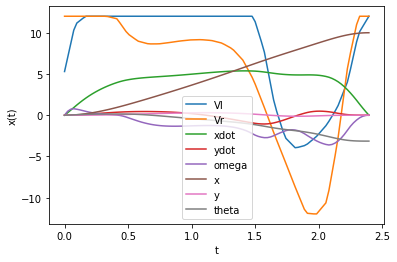

Time:  2.396


In [17]:
xtraj, utraj = trajgen_collocation(10, 0, -np.pi, 5, Q=5, R=1, num_pts=30, addl_constraints=[])
tvec, dat = plot_traj(xtraj, utraj)

In [22]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

## 180° flip w/ -1cm < y < 1cm constraint

In [23]:
xtraj, utraj = trajgen_collocation(10, 0, -np.pi, 5, Q=10, R=1, num_pts=60, addl_constraints=[
    'dircol.AddConstraintToAllKnotPoints(x[4] <= 0.01)',
    'dircol.AddConstraintToAllKnotPoints(-0.01 <= x[4])'
])
tvec, dat = plot_traj(xtraj, utraj)

SNOPT/fortran


AssertionError: 

In [71]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

## 180° flip w/ high control effort penalty

In [ ]:
xtraj, utraj = trajgen_collocation(10, 0, -np.pi, 5, Q=0.5, R=1, num_pts=60, addl_constraints=[])
tvec, dat = plot_traj(xtraj, utraj)

In [ ]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

## 180° flip w/ high time penalty

In [ ]:
xtraj, utraj = trajgen_collocation(10, 0, -np.pi, 5, Q=50, R=1, num_pts=60, addl_constraints=[])
tvec, dat = plot_traj(xtraj, utraj)

In [ ]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

# S-curve, balanced control effort/time penalties

In [ ]:
xtraj, utraj = trajgen_collocation(10, 10, 0, 5, Q=5, R=1, num_pts=30, addl_constraints=[])
tvec, dat = plot_traj(xtraj, utraj)

In [ ]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

# S-curve dash, high control effort penalties

In [ ]:
xtraj, utraj = trajgen_collocation(10, 10, 0, 5, Q=0.1, R=1, num_pts=30, addl_constraints=[])
tvec, dat = plot_traj(xtraj, utraj)

In [ ]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

# S-curve, high time penalties

In [ ]:
xtraj, utraj = trajgen_collocation(10, 10, 0, 5, Q=5000, R=0.1, num_pts=60, addl_constraints=[
    'dircol.AddConstraintToAllKnotPoints(x[3] + x[4] <= 20)',
])
tvec, dat = plot_traj(xtraj, utraj)

In [ ]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

# Obstacle Traversal (balanced)

In [46]:
xtraj, utraj = trajgen_collocation(0, 5, -np.pi/2, 10, Q=5, R=1, num_pts=60, addl_constraints=[
    'dircol.AddConstraintToAllKnotPoints(4 <= ((x[3]**2) + (x[4]**2) + 0.01)**0.5)',
], start_state=[0, -5, np.pi/2])
tvec, dat = plot_traj(xtraj, utraj)

SNOPT/fortran
Solve time: 45.948121070861816


Time:  3.544


In [47]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

# Obstacle Traversal (Control effort optimized)

SNOPT/fortran
Solve time: 37.577839374542236


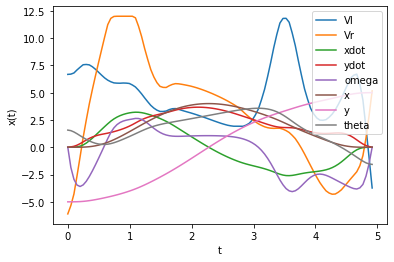

Time:  4.917


In [52]:
xtraj, utraj = trajgen_collocation(0, 5, -np.pi/2, 5, Q=0.1, R=1, num_pts=60, addl_constraints=[
    'dircol.AddConstraintToAllKnotPoints(4 <= ((x[3]**2) + (x[4]**2) + 0.01)**0.5)',
], start_state=[0, -5, np.pi/2])
tvec, dat = plot_traj(xtraj, utraj)

In [53]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

# Obstacle Traversal (Speed optimized)

SNOPT/fortran
Solve time: 18.90015411376953


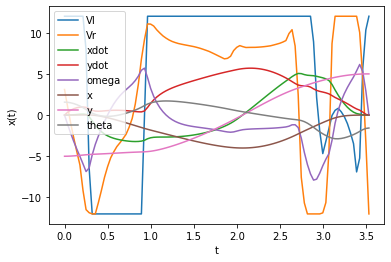

Time:  3.534


In [48]:
xtraj, utraj = trajgen_collocation(0, 5, -np.pi/2, 10, Q=50, R=1, num_pts=60, addl_constraints=[
    'dircol.AddConstraintToAllKnotPoints(4 <= ((x[3]**2) + (x[4]**2) + 0.01)**0.5)',
], start_state=[0, -5, np.pi/2])
tvec, dat = plot_traj(xtraj, utraj)

In [49]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

# Obstacle Traversal (Circle constraint)

SNOPT/fortran
Solve time: 62.6210834980011


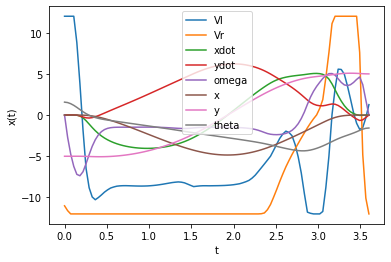

Time:  3.601


In [67]:
xtraj, utraj = trajgen_collocation(0, 5, -np.pi/2, 10, Q=5, R=1, num_pts=60, addl_constraints=[
    'dircol.AddConstraintToAllKnotPoints(4.85 <= ((x[3]**2) + (x[4]**2) + 0.01)**0.5)',
    'dircol.AddConstraintToAllKnotPoints(((x[3]**2) + (x[4]**2) + 0.01)**0.5 <= 5.15)',
], start_state=[0, -5, np.pi/2])
tvec, dat = plot_traj(xtraj, utraj)

In [68]:
animate_results(tvec, dat.T, animation_fps=30, speed_multiple=1, use_html5_video=True, save=True)

In [6]:
DifferentiableRobotSystem_[None]

pydrake.systems.scalar_conversion.DifferentiableRobotSystem_[float]

In [8]:
from pydrake.autodiffutils import AutoDiffXd
DifferentiableRobotSystem_[AutoDiffXd]

pydrake.systems.scalar_conversion.DifferentiableRobotSystem_[AutoDiffXd]

In [15]:
sys = DifferentiableRobotSystem_[AutoDiffXd]()

In [16]:
sys.CreateDefaultContext()

<pydrake.systems.framework.LeafContext_[AutoDiffXd] at 0x7f85726332b0>

In [37]:
%prun trajgen_collocation(10, 0, -np.pi, 5, Q=5, R=1, num_pts=30, addl_constraints=[])

SNOPT/fortran
Solve time: 3.8537046909332275
 

In [39]:
%lprun -f trajgen_collocation trajgen_collocation(10, 0, -np.pi, 5, Q=5, R=1, num_pts=30, addl_constraints=[])

SNOPT/fortran
Solve time: 1.8622686862945557


In [40]:
%lprun -f DifferentiableRobotSystem.f trajgen_collocation(10, 0, -np.pi, 5, Q=5, R=1, num_pts=30, addl_constraints=[])

SNOPT/fortran
Solve time: 2.1471803188323975
